Dataset https://www.kaggle.com/datasets/chronozone/indonesian-stocks

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


In [ ]:
# Baca dataset
data = pd.read_csv('/content/drive/MyDrive/dataset/INCO.csv', parse_dates=['Date'])
data = data.set_index('Date')

# Tentukan fitur yang akan digunakan
features = ['Open', 'High', 'Low', 'Close']
data = data[features]

# Normalisasi data menggunakan MinMaxScaler
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

# Tentukan panjang time series
sequence_length = data_normalized.shape[0]
num_features = data_normalized.shape[1]

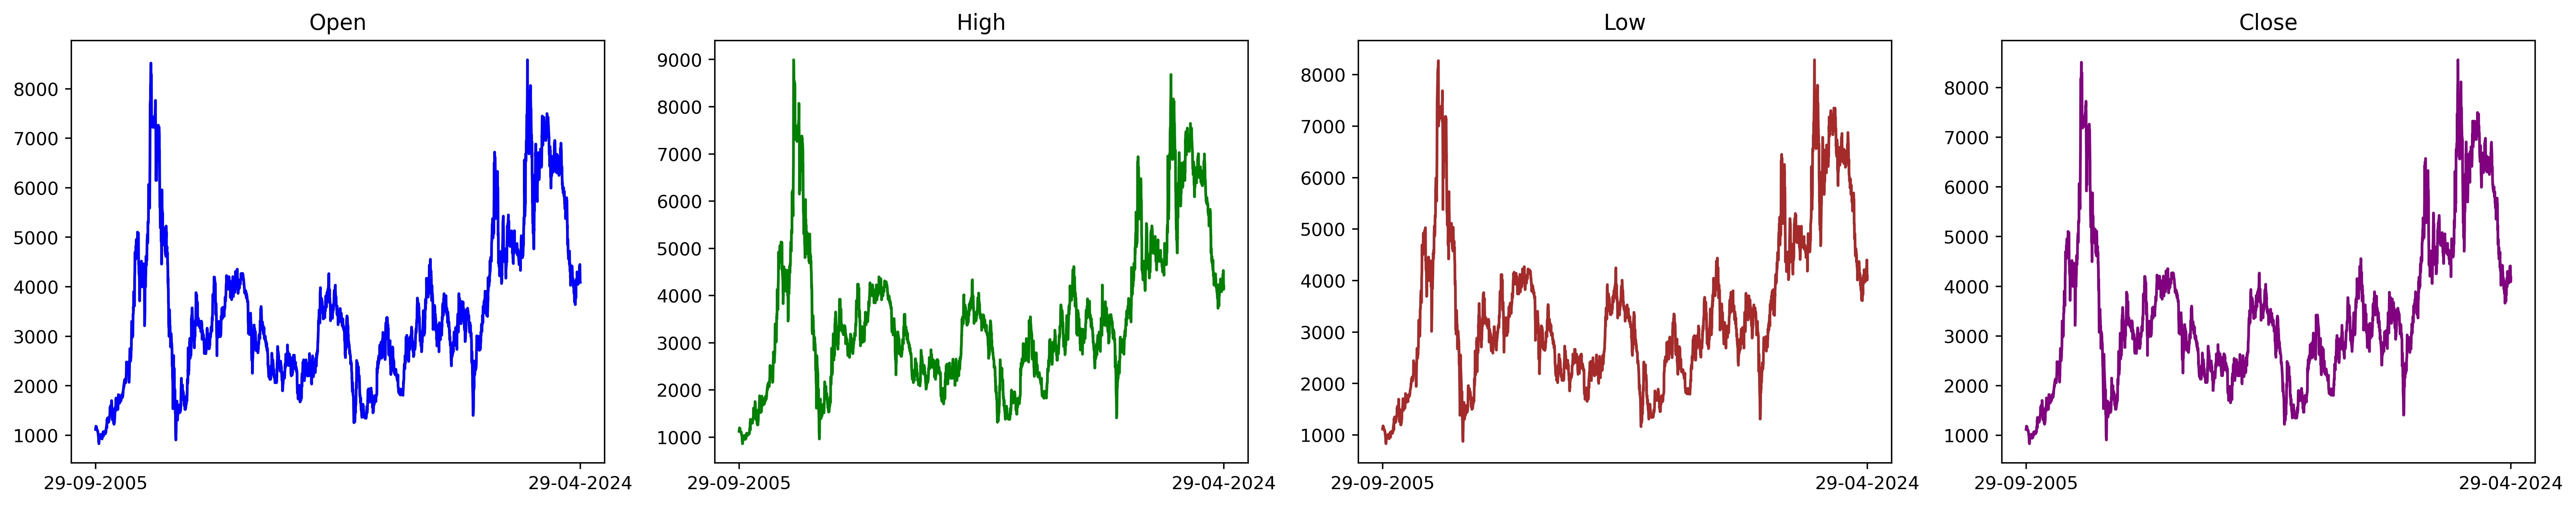

In [ ]:
def tampil_data(df):
    start_date = df.index.min()
    end_date = df.index.max()
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 4), dpi=400)
    colors = ['blue', 'green', 'brown', 'purple']
    for ax, col, color in zip(axes, features, colors):
        ax.plot(df.index, df[col], color=color)
        ax.set_title(col)
        ax.set_xticks([start_date, end_date])
        ax.set_xticklabels([start_date.strftime('%d-%m-%Y'), end_date.strftime('%d-%m-%Y')])
    plt.tight_layout()
    plt.show()

tampil_data(data)


In [ ]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, data, window_size):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        return self.data[idx:idx + self.window_size]


class AYTS(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AYTS, self).__init__()
        self.encoder = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.regressor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        _, h = self.encoder(x)
        out = self.regressor(h.squeeze(0))
        return out


def train_ayts_model(data, window_size=20, epochs=100, lr=0.001, batch_size=64):
    dataset = TimeSeriesDataset(data, window_size)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = AYTS(input_dim=data.shape[1], hidden_dim=64, output_dim=data.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    model.train()
    losses = []
    for epoch in range(epochs):
        for batch in dataloader:
            batch = batch.to(device)
            output = model(batch)
            target = batch[:, -1, :]
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(loss.item())
        if (epoch + 1) % (epochs // 10) == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")
    return model, losses





In [ ]:
model, losses = train_ayts_model(data_normalized, window_size=20, epochs=100)

Epoch [10/100], Loss: 0.000074
Epoch [20/100], Loss: 0.000027
Epoch [30/100], Loss: 0.000034
Epoch [40/100], Loss: 0.000025
Epoch [50/100], Loss: 0.000021
Epoch [60/100], Loss: 0.000026
Epoch [70/100], Loss: 0.000029
Epoch [80/100], Loss: 0.000021
Epoch [90/100], Loss: 0.000008
Epoch [100/100], Loss: 0.000007


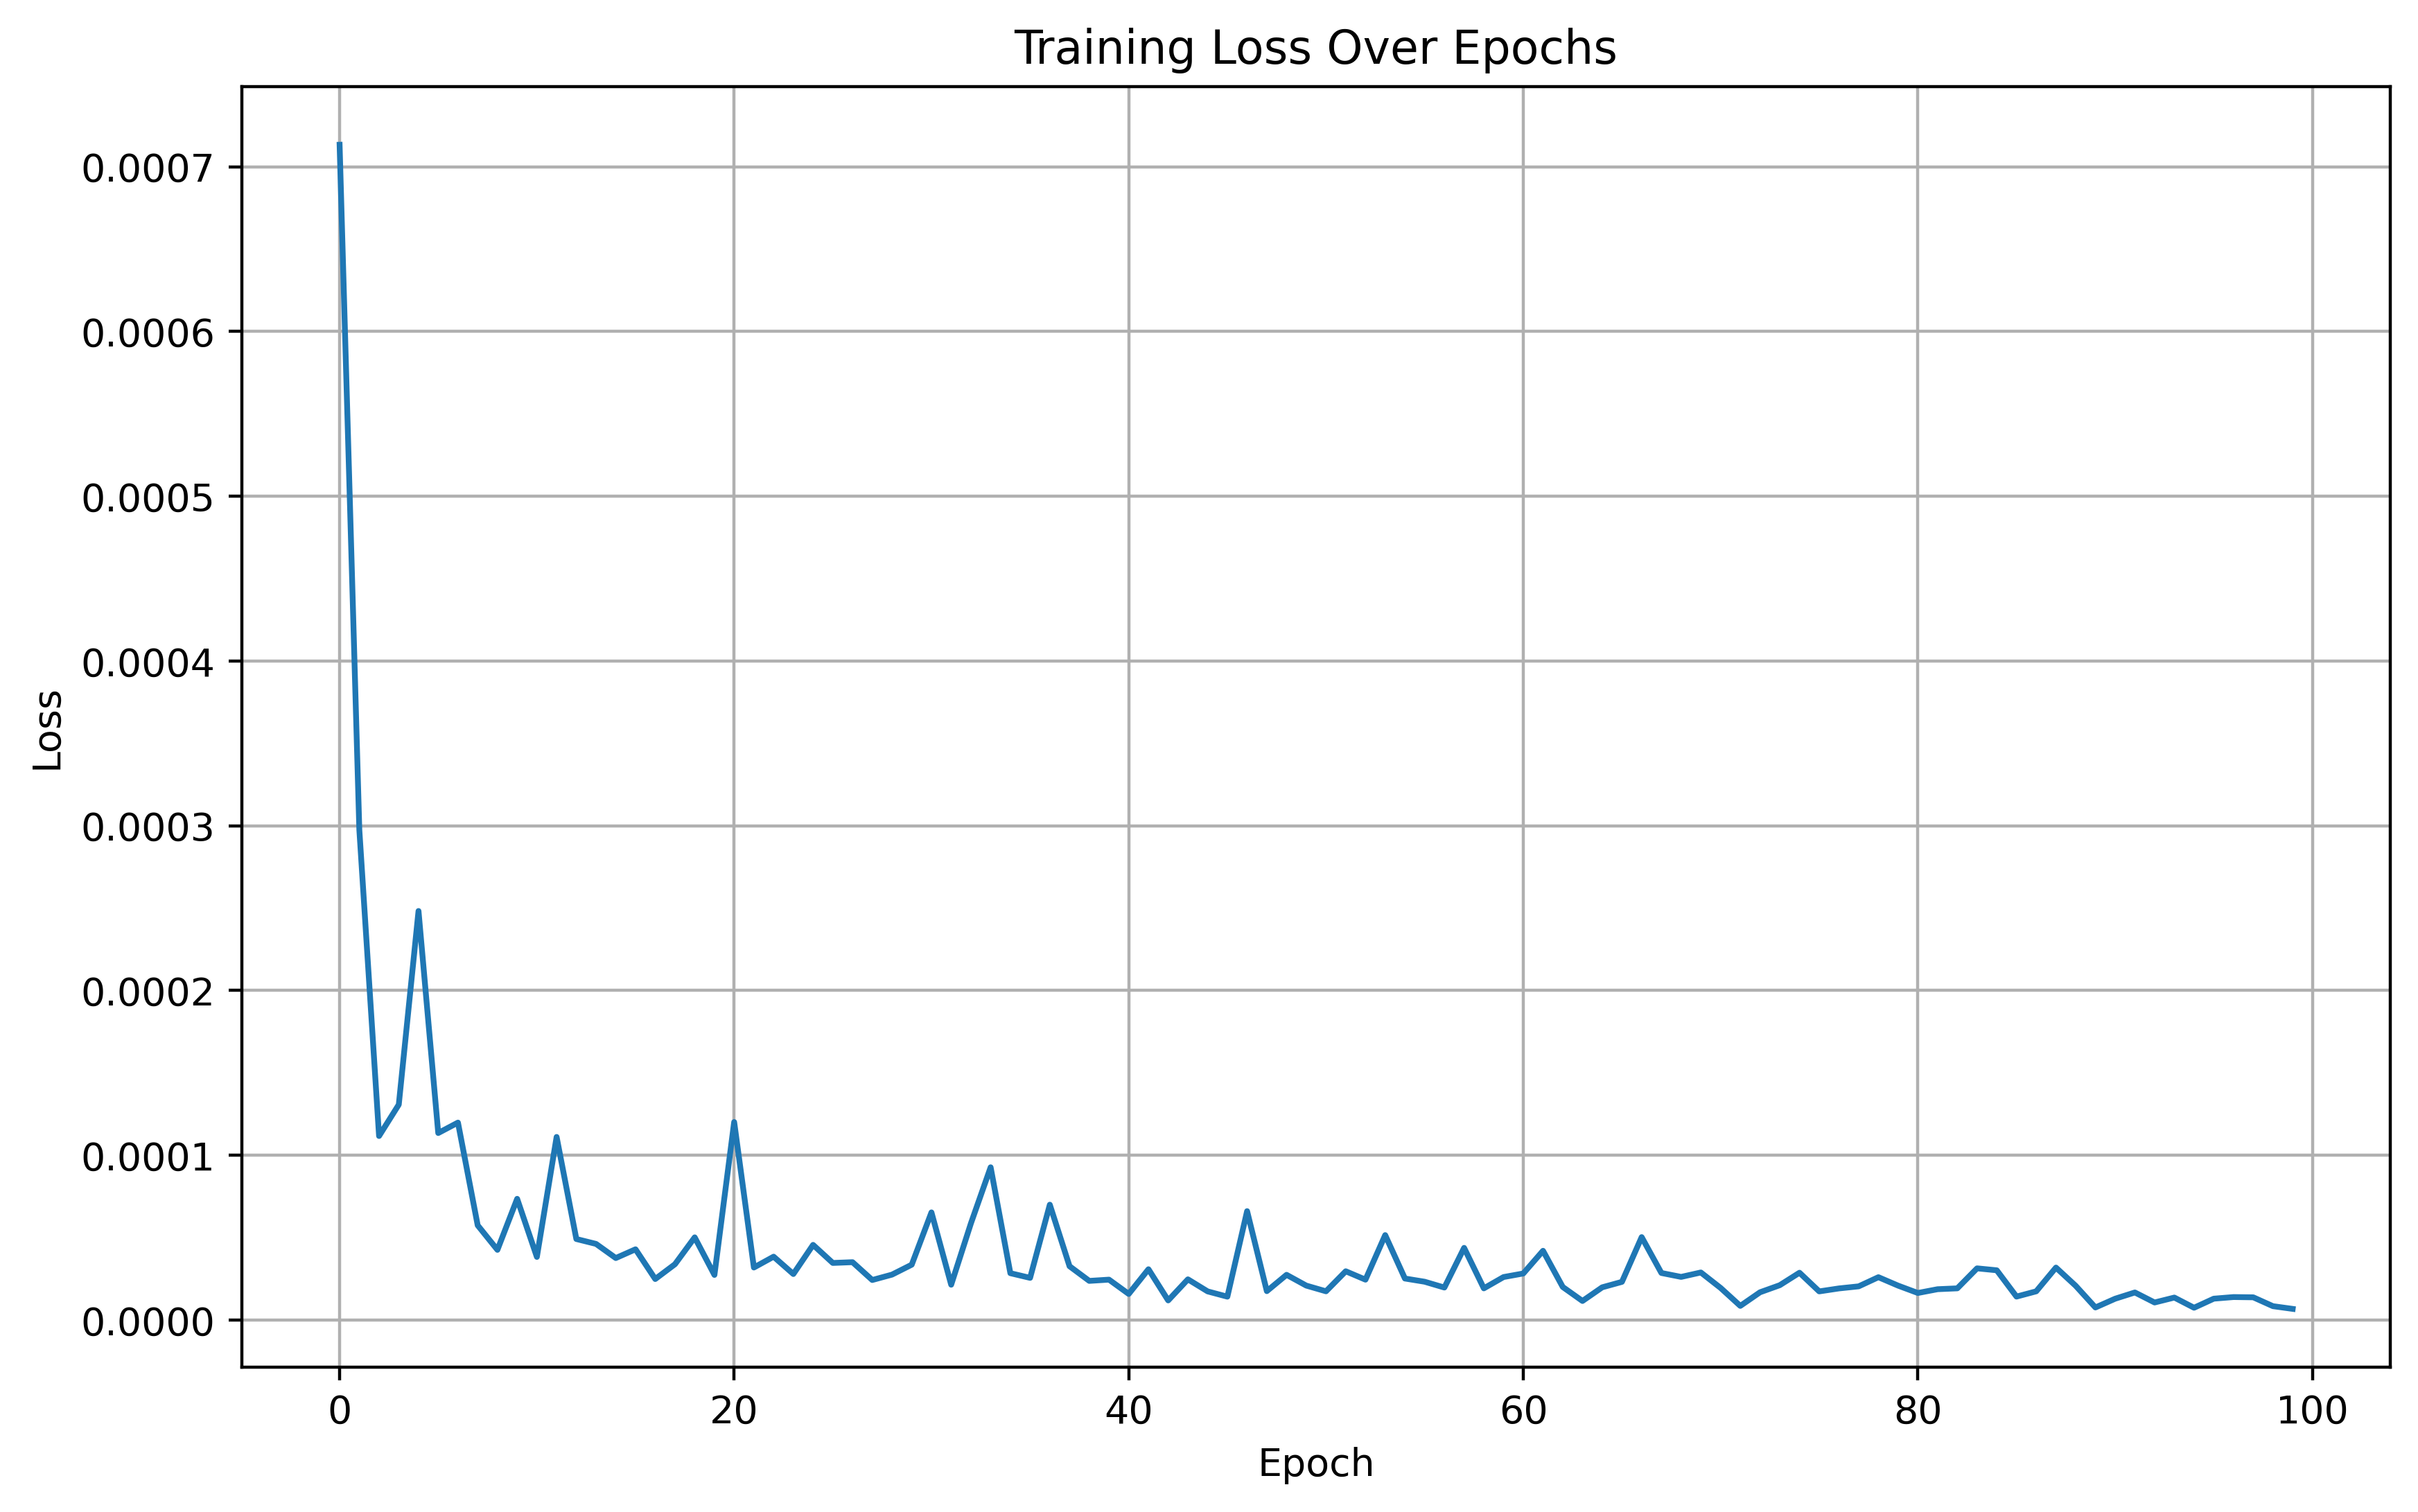

In [ ]:
plt.figure(figsize=(10, 6), dpi=400)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()


In [ ]:
def evaluate_model(model, data, window_size=20):
    model.eval()
    inputs, outputs = [], []
    with torch.no_grad():
        for i in range(len(data) - window_size):
            seq = torch.tensor(data[i:i+window_size], dtype=torch.float32).unsqueeze(0).to(device)
            output = model(seq)
            outputs.append(output.squeeze(0).cpu().numpy())
            inputs.append(data[i+window_size-1])
    return np.array(inputs), np.array(outputs)

y_truenorm, y_prednorm = evaluate_model(model, data_normalized)
y_true = scaler.inverse_transform(y_truenorm)
y_pred = scaler.inverse_transform(y_prednorm)


In [ ]:
def calculate_metrics(y_true, y_pred):
    metrics_list = []
    for i, f in enumerate(features):
        mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
        mse = mean_squared_error(y_true[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true[:, i], y_pred[:, i])
        ks_stat, ks_p = ks_2samp(y_true[:, i], y_pred[:, i])
        metrics_list.append({
            'Feature': f, 'MAE': mae, 'MSE': mse,
            'RMSE': rmse, 'R2': r2,
            'KS Statistic': ks_stat, 'KS P-Value': ks_p
        })
    return pd.DataFrame(metrics_list)

y_original = pd.DataFrame(y_true, columns=features)
y_synthetic = pd.DataFrame(y_pred, columns=features)
metrics_df = calculate_metrics(y_true, y_pred)
print(metrics_df)


  Feature        MAE          MSE       RMSE        R2  KS Statistic  \
0    Open  15.731109   430.005321  20.736570  0.999810      0.008613   
1    High  28.176075  1081.208722  32.881738  0.999535      0.014506   
2     Low  13.659102   396.348390  19.908500  0.999818      0.004760   
3   Close  13.414443   373.726136  19.331998  0.999834      0.005213   

   KS P-Value  
0    0.996711  
1    0.742137  
2    1.000000  
3    1.000000  


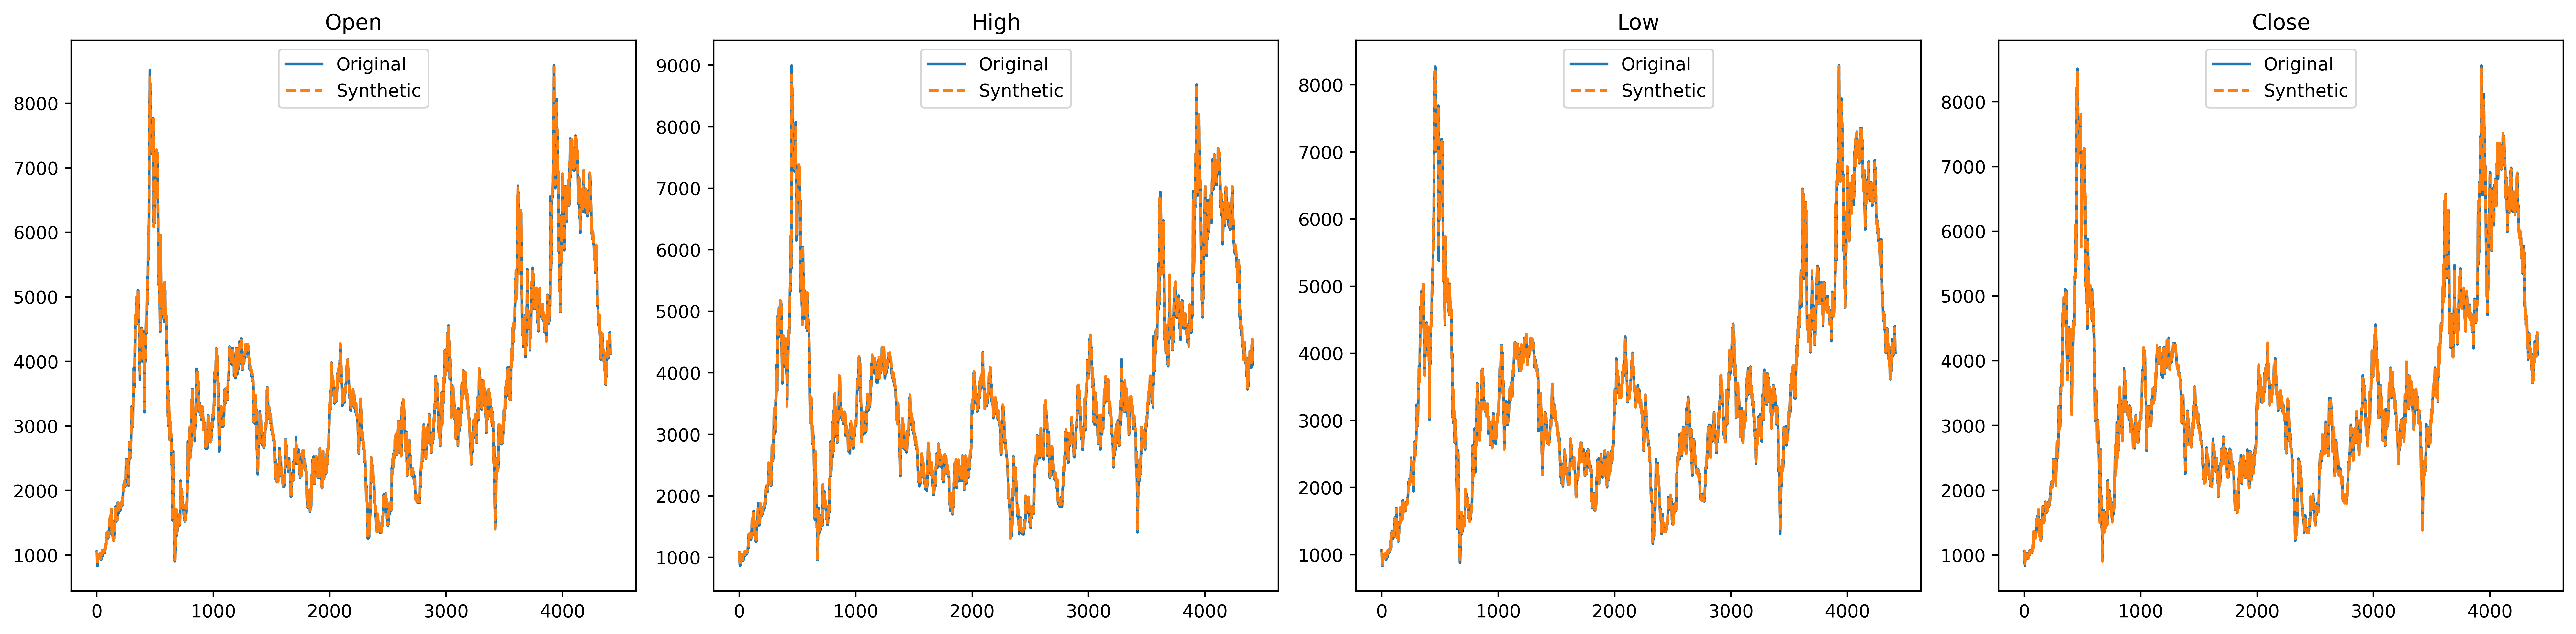

In [ ]:
def plotfeatures(original, synthetic):
    fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(20, 5), dpi=400)
    for i, col in enumerate(features):
        axes[i].plot(original[col], label='Original')
        axes[i].plot(synthetic[col], label='Synthetic', linestyle='dashed')
        axes[i].set_title(col)
        axes[i].legend()
    plt.tight_layout()
    plt.show()

plotfeatures(y_original, y_synthetic)


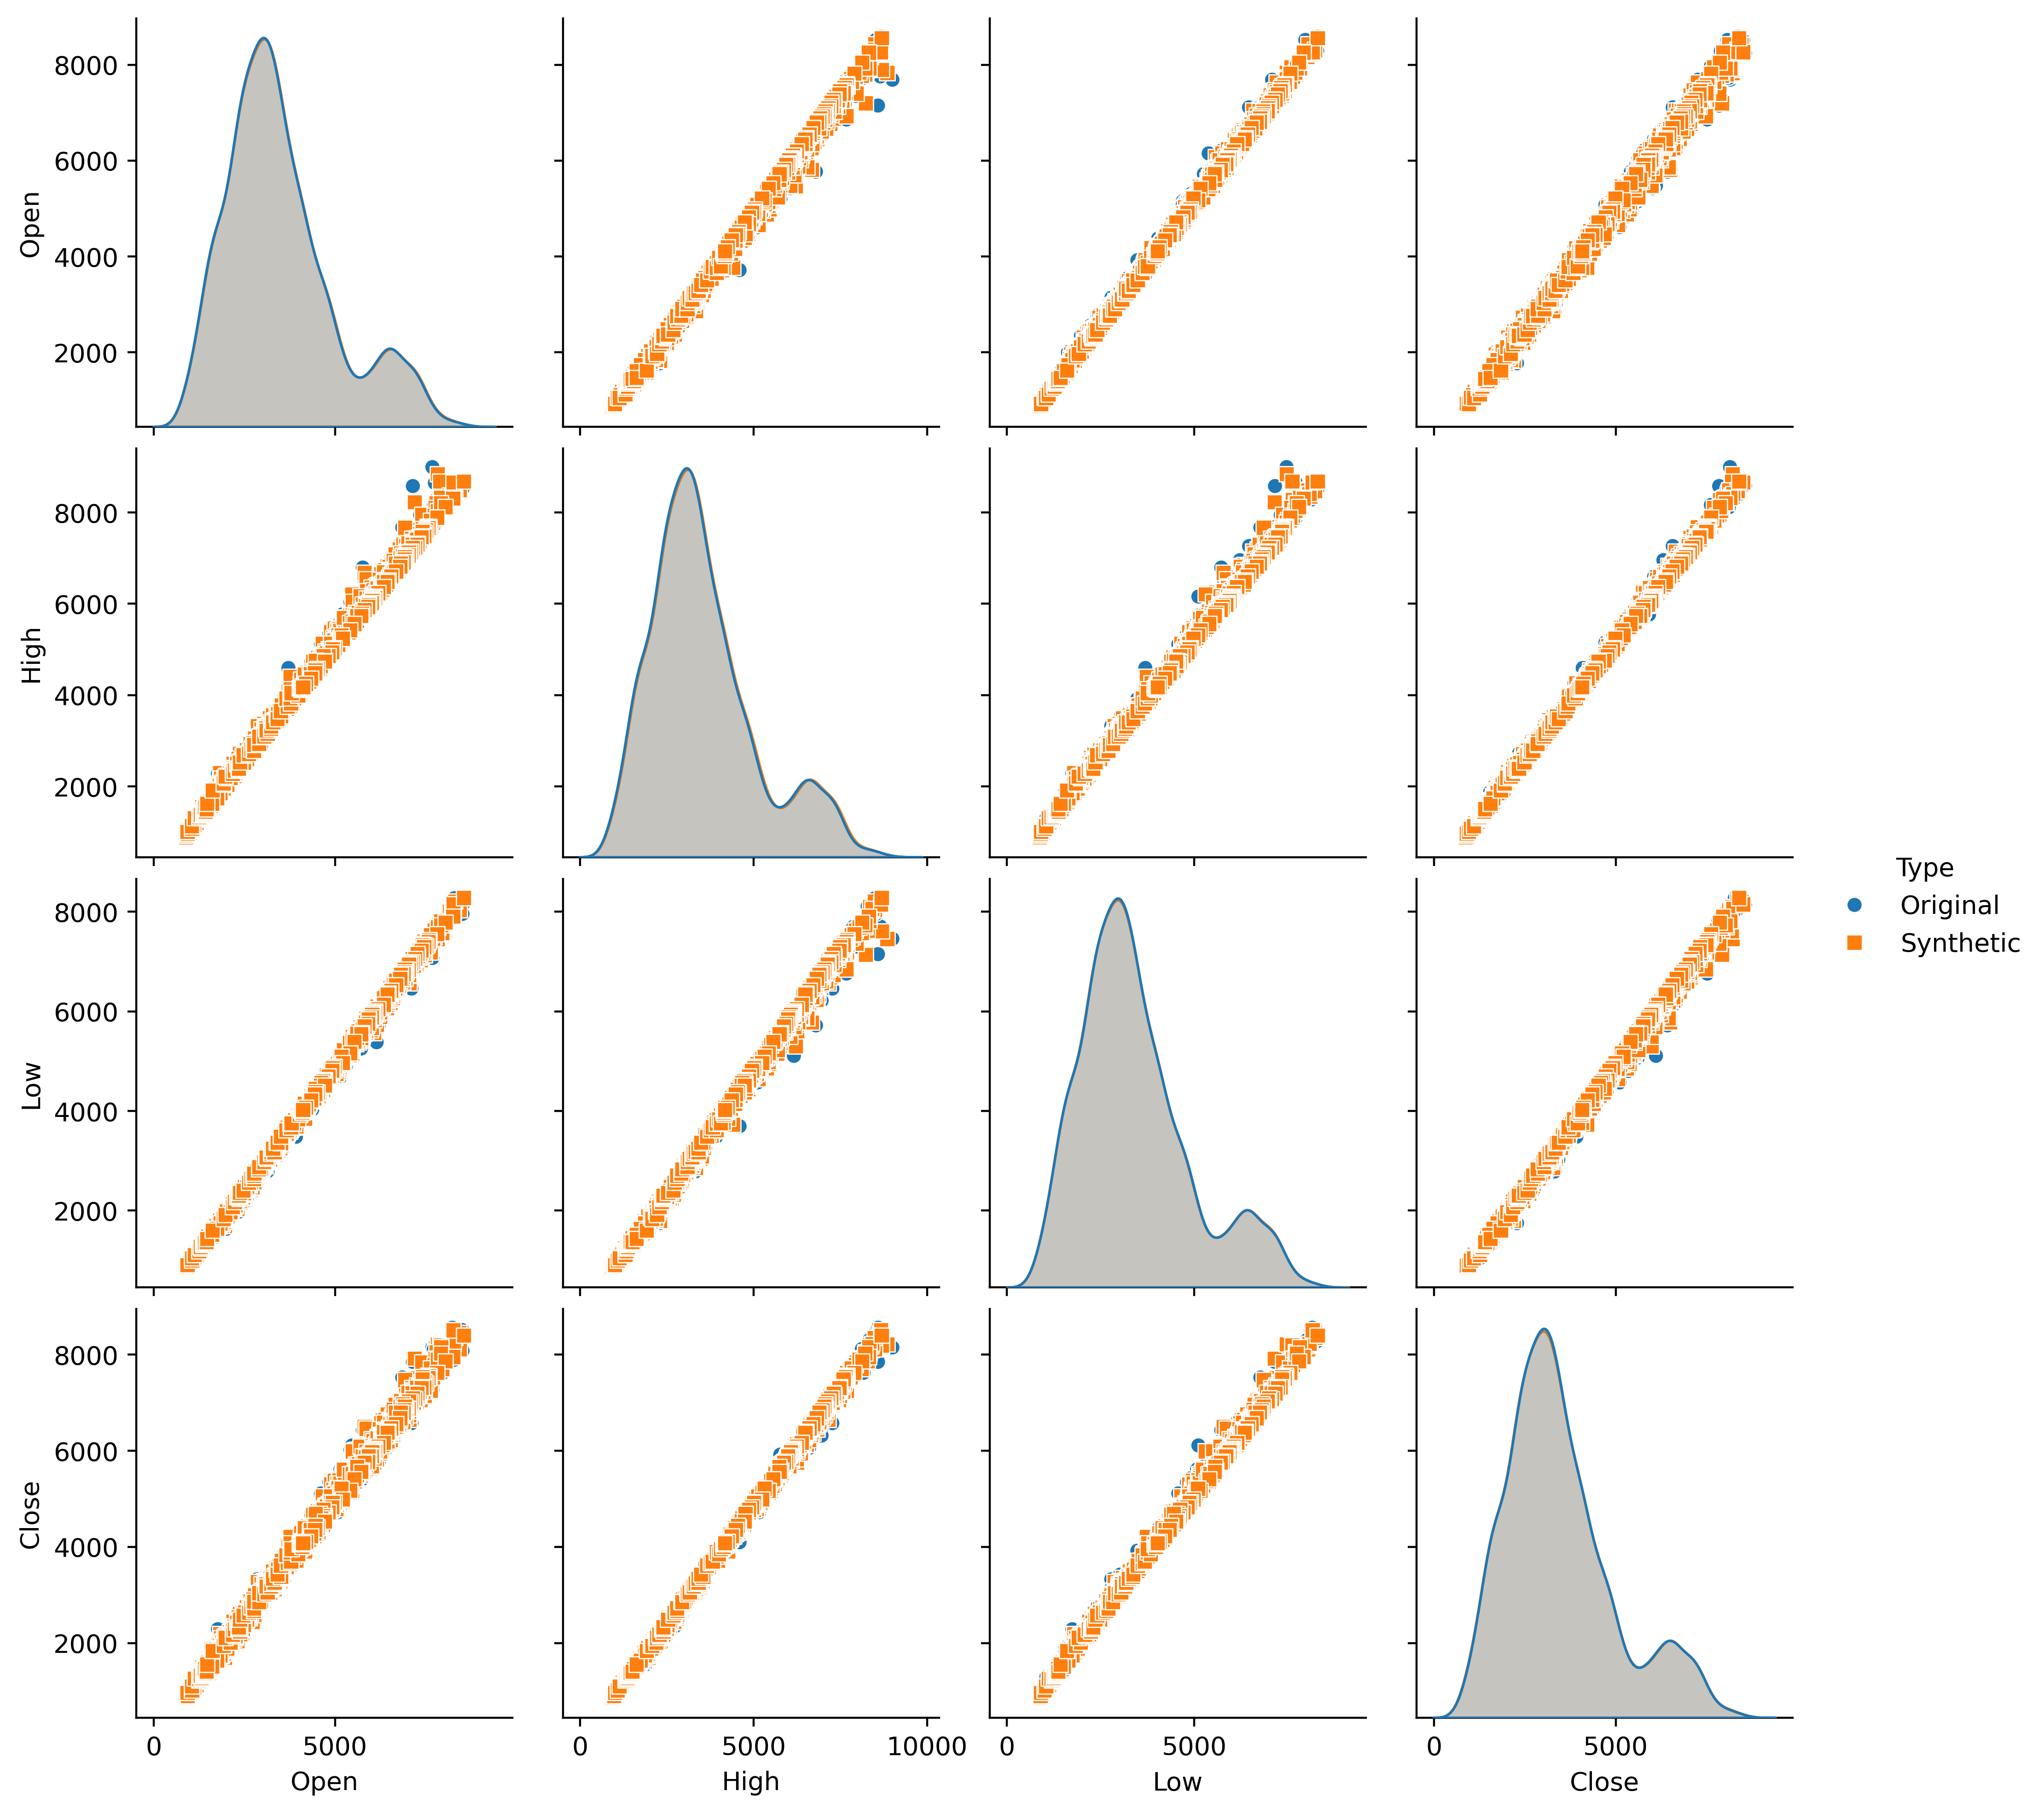

In [ ]:
def plot_pairplot(data_original, data_synthetic):
    data_original['Type'] = 'Original'
    data_synthetic['Type'] = 'Synthetic'
    combined_data = pd.concat([data_original, data_synthetic])
    g = sns.pairplot(combined_data, hue='Type', markers=['o', 's'], diag_kind='kde')
    g.fig.set_dpi(400)
    plt.show()

plot_pairplot(y_original, y_synthetic)

In [ ]:
print("\nOriginal")
print("------------------------")
print(y_original.describe())

print("\nSynthetic")
print("------------------------")
print(y_synthetic.describe())


Original
------------------------
              Open         High          Low        Close
count  4412.000000  4412.000000  4412.000000  4412.000000
mean   3479.255893  3539.013146  3414.199683  3473.549637
std    1503.107762  1524.259071  1475.542996  1498.670236
min     831.000000   860.000000   831.000000   831.000000
25%    2437.000000  2482.000000  2380.000000  2431.750000
50%    3193.000000  3247.000000  3137.000000  3190.500000
75%    4173.000000  4226.000000  4120.000000  4170.750000
max    8583.000000  8993.000000  8287.000000  8558.000000

Synthetic
------------------------
              Open         High          Low        Close
count  4412.000000  4412.000000  4412.000000  4412.000000
mean   3488.174072  3564.378174  3414.606201  3471.316162
std    1505.328979  1528.177124  1477.183716  1502.868042
min     863.266418   876.534729   847.074646   844.085938
25%    2440.315674  2505.020325  2372.820496  2426.237793
50%    3203.141113  3268.179688  3133.048828  3188.758301
7